# Train the Generative Model for Accurate Labeling

This notebook is designed to run the generative model snorkel uses for estimating the probability of each candidate being a true candidate (label of 1). 

## MUST RUN AT THE START OF EVERYTHING

Import the necessary modules and set up the database for database operations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from collections import defaultdict
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel import SnorkelSession
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, save_marginals
from snorkel.learning import GenerativeModel
from snorkel.learning.utils import MentionScorer
from snorkel.models import Candidate, FeatureKey, candidate_subclass
from snorkel.utils import get_as_dict
from tree_structs import corenlp_to_xmltree
from treedlib import compile_relation_feature_generator

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load preprocessed data 

This code will load the label matrix that was generated in the previous notebook ([Notebook 2](2.data-labeler.ipynb)). **Disclaimer**: this block might break, which means that the snorkel code is still using its old code. The problem with the old code is that sqlalchemy will attempt to load all the labels into memory. Doesn't sound bad if you keep the amount of labels small, but doesn't scale when the amount of labels increases exponentially. Good news is that there is a pull request to fix this issue. [Check it out here!](https://github.com/HazyResearch/snorkel/pull/789)

In [6]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='danich1', split=0)
annotated_cands_train_ids = list(map(lambda x: L_gold_train.row_index[x], L_gold_train.nonzero()[0]))

L_gold_dev = load_gold_labels(session, annotator_name='danich1', split=1)
annotated_cands_dev_ids = list(map(lambda x: L_gold_dev.row_index[x], L_gold_dev.nonzero()[0]))

In [7]:
%%time
labeler = LabelAnnotator(lfs=[])

# Only grab candidates that have human labels
#cids = session.query(Candidate.id).filter(Candidate.id.in_(annotated_cands_train_ids))
L_train = labeler.load_matrix(session, split=0) #cids_query=cids)

#cids = session.query(Candidate.id).filter(Candidate.id.in_(annotated_cands_dev_ids))
#L_dev = labeler.load_matrix(session,cids_query=cids)

CPU times: user 4.67 s, sys: 198 ms, total: 4.87 s
Wall time: 6.93 s


In [8]:
print("Total Data Shape:")
print(L_train.shape)

Total Data Shape:
(2715766, 11)


In [9]:
L_train = L_train[np.unique(L_train.nonzero()[0]), :]
print("Total Data Shape:")
print(L_train.shape)

Total Data Shape:
(1000, 11)


# Train the Generative Model

Here is the first step of classification step of this project, where we train a gnerative model to discriminate the correct label each candidate will receive. Snorkel's generative model uses a Gibbs Sampling on a [factor graph](http://deepdive.stanford.edu/assets/factor_graph.pdf), to generate the probability of a potential candidate being a true candidate (label of 1).

In [10]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=30, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6, threads=50, verbose=True)

Inferred cardinality: 2
FACTOR 0: STARTED BURN-IN...
FACTOR 0: DONE WITH BURN-IN
FACTOR 0: STARTED LEARNING
FACTOR 0: EPOCH #0
Current stepsize = 0.0001
Learning epoch took 0.000 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  0.0

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  0.0

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  0.0

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  0.0

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  0.0

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  0.0

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
 

FACTOR 0: EPOCH #6
Current stepsize = 7.350918906249998e-05
Learning epoch took 0.010 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  0.0320479908787

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  0.159639013957

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  0.0830446570785

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  0.0524277069803

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.340521361408

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.607629920526

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False


FACTOR 0: EPOCH #12
Current stepsize = 5.4036008766263664e-05
Learning epoch took 0.010 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  0.0398526231408

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  0.256220923564

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  0.111258680943

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  0.0879079034978

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.504443154025

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.864934924757

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False

FACTOR 0: EPOCH #18
Current stepsize = 3.972143184582182e-05
Learning epoch took 0.010 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  0.0266476048497

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  0.316807379215

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  0.124042293388

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  0.11553470816

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.579893215424

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.982718130559

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False
  

FACTOR 0: EPOCH #24
Current stepsize = 2.9198902433877236e-05
Learning epoch took 0.011 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  0.0196380625375

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  0.358816606678

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  0.138561637561

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  0.139393754387

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.619915357098

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -1.04705466621

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False
 

        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -1.08135220921

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False
        weight:  -0.993027093409

    weightId: 14
        isFixed: True
        weight:  1.0

    weightId: 15
        isFixed: False
        weight:  -0.861369309

    weightId: 16
        isFixed: True
        weight:  1.0

    weightId: 17
        isFixed: False
        weight:  -0.809475465418

    weightId: 18
        isFixed: True
        weight:  1.0

    weightId: 19
        isFixed: False
        weight:  -0.788168190301

    weightId: 20
        isFixed: True
        weight:  1.0

    weightId: 21
        isFixed: False
        weight:  -0.807068643787

FACTOR 0: DONE WITH LEARNING
CPU times: user 1.57 s, sys: 110 ms, total: 1.68 s
Wall time: 822 ms


In [11]:
gen_model.weights.lf_accuracy

array([  1.01833812e+00,   1.39048816e+00,   1.14040804e+00,
         1.15398462e+00,   3.59763701e-01,  -8.56901229e-02,
         7.59724192e-04,   1.36168033e-01,   1.88016687e-01,
         2.07448696e-01,   1.88005998e-01])

In [12]:
from utils.disease_gene_lf import LFS
learned_stats_df = gen_model.learned_lf_stats()
learned_stats_df.index = list(LFS)
learned_stats_df

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Accuracy,Coverage,Precision,Recall
LF_HETNET_DISEASES,0.890540,0.7537,0.877654,0.667516
LF_HETNET_DOAF,0.941257,0.8035,0.939024,0.752496
LF_HETNET_DisGeNET,0.911471,0.7715,0.900624,0.704695
LF_HETNET_GWAS,0.904682,0.7732,0.895279,0.701083
LF_CHECK_GENE_TAG,0.676514,0.6838,0.655488,0.456767
LF_IS_BIOMARKER,0.453798,0.6688,0.423907,0.300616
LF_ASSOCIATION,0.498719,0.6633,0.469048,0.323561
LF_NO_ASSOCIATION,0.556737,0.6680,0.525538,0.362864
LF_NO_CONCLUSION,0.585836,0.6693,0.554652,0.391332
LF_DG_DISTANCE,0.598659,0.6710,0.566596,0.398555


In [13]:
%time train_marginals = gen_model.marginals(L_train)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


In [14]:
print(len(train_marginals[train_marginals > 0.5]))

186


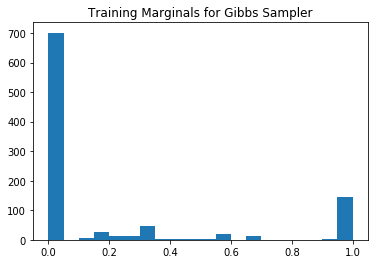

In [15]:
plt.hist(train_marginals, bins=20)
plt.title("Training Marginals for Gibbs Sampler")
plt.show()

In [ ]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_train, L_gold_train)

In [ ]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fn, session)
else:
    sv = None

In [ ]:
sv

In [ ]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

In [ ]:
c.labels

In [ ]:
c.Gene_cid

In [ ]:
L_train.lf_stats(session, L_gold_train[L_gold_train!=0].T, gen_model.learned_lf_stats()['Accuracy'])

# Save Training Marginals

Save the training marginals for [Notebook 4](4.data-disc-model).

In [ ]:
np.savetxt("vanilla_lstm/lstm_disease_gene_holdout/subsampled/train_marginals_subsampled.txt", train_marginals)

In [ ]:
#%time save_marginals(session, L_train, train_marginals)